In [1]:
import numpy as np

from dmipy.core.acquisition_scheme import acquisition_scheme_from_bvalues
from dmipy.signal_models import cylinder_models, gaussian_models
from dmipy.core.modeling_framework import MultiCompartmentModel

import matplotlib.pyplot as plt

import config
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as utils
from tqdm import tqdm

import process_data

In [2]:
scan_100206 = process_data.get_nifti_data(config.data_folder2 + '/100206/data.nii.gz')
mask_100206 = process_data.get_nifti_data(config.data_folder2 + '/100206/nodif_brain_mask.nii.gz')

In [3]:
scan_dimension = scan_100206.shape
x = scan_dimension[0]
y = scan_dimension[1]
z = scan_dimension[2]
b = scan_dimension[3]

In [4]:
scan_100206_long = np.reshape(scan_100206, (x*y*z, b))

mask_100206_long = np.reshape(mask_100206, (x*y*z, 1))

In [5]:
# Error voxels
indice_beginning_0_all = np.where(scan_100206_long[:, 0] == 0)[0]

In [6]:
mask_100206_long_pro = np.copy(mask_100206_long)
mask_100206_long_pro[indice_beginning_0_all] = 0

In [7]:
scan_100206_long_no_background = process_data.remove_background(scan_100206_long, mask_100206_long_pro)

In [8]:
bvals_all_100206 = np.loadtxt(config.data_folder2 + '/100206/bvals')

In [9]:
S0_100206 = process_data.get_S0(scan_100206_long_no_background, bvals_all_100206*1e-3)

In [10]:
normalized_scan_100206_full = scan_100206_long_no_background / S0_100206

In [11]:
normalized_scan_100206_full.shape

(935442, 288)

In [12]:
rand_7g_bval_indice_100206 = np.array(process_data.get_rand_selected_bval_indice(bvals_all_100206, 7))

In [13]:
rand_7g_bval_indice_100206

array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
        13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
        26,  27,  28,  29,  30,  31,  64,  65,  66,  67,  68,  69,  70,
        71,  72,  73,  74,  75,  76,  77,  78,  79, 128, 129, 130, 131,
       132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 176,
       177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189,
       190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202,
       203, 204, 205, 206, 207, 272, 273, 274, 275, 276, 277, 278, 279,
       280, 281, 282, 283, 284, 285, 286, 287])

In [14]:
bvals_100206_7g = bvals_all_100206[rand_7g_bval_indice_100206]*1e-3

In [15]:
normalized_scan_100206_7g = normalized_scan_100206_full[:, rand_7g_bval_indice_100206]

In [16]:
big_b_indice_100206_7g = np.where(bvals_100206_7g != 0.005)[0]

In [17]:
big_b_indice_100206_7g

array([  1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,  13,
        14,  15,  17,  18,  19,  20,  21,  22,  23,  24,  25,  26,  27,
        28,  29,  30,  31,  33,  34,  35,  36,  37,  38,  39,  40,  41,
        42,  43,  44,  45,  46,  47,  49,  50,  51,  52,  53,  54,  55,
        56,  57,  58,  59,  60,  61,  62,  63,  65,  66,  67,  68,  69,
        70,  71,  72,  73,  74,  75,  76,  77,  78,  80,  81,  82,  83,
        84,  85,  86,  87,  88,  89,  90,  91,  92,  93,  94,  95,  97,
        98,  99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110,
       111])

In [18]:
bvals_100206_7g_no_b5 = bvals_100206_7g[big_b_indice_100206_7g]

In [19]:
normalized_scan_100206_7g_no_b5 = normalized_scan_100206_7g[:, big_b_indice_100206_7g]

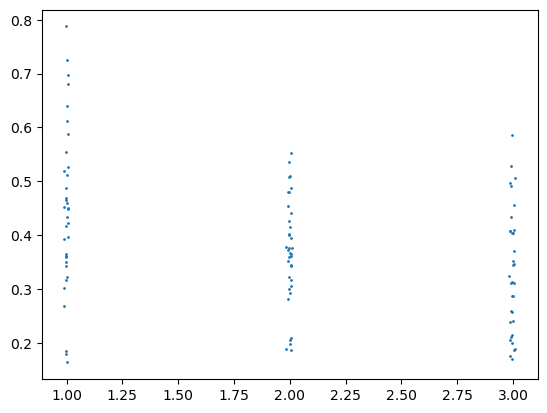

In [20]:
plt.plot(bvals_100206_7g_no_b5, normalized_scan_100206_7g_no_b5[42,:], "o", markersize = 1)

ANN

In [21]:
def squash(param, p_min, p_max):
    squashed_param_tensor =torch.clamp(param, min=p_min, max=p_max)
    unsqueezed_param = squashed_param_tensor.unsqueeze(1)
    return unsqueezed_param

In [22]:
def unitsphere2cart(theta, phi, X):
    mu_cart = torch.zeros(3,X.size()[0])
    sintheta = torch.sin(theta)
    mu_cart[0,:] = torch.squeeze(sintheta * torch.cos(phi))
    mu_cart[1,:] = torch.squeeze(sintheta * torch.sin(phi))
    mu_cart[2,:] = torch.squeeze(torch.cos(theta))
    return mu_cart

In [23]:
class BallStickNet(nn.Module):
    
    def __init__(self, gradient_directions, b_values):
        super(BallStickNet, self).__init__()
        self.gradient_directions = gradient_directions
        self.b_values = b_values
        self.fc_layers = nn.ModuleList()
        for i in range(3): 
            self.fc_layers.extend([nn.Linear(len(b_values), len(b_values)), nn.ELU()])
        self.encoder = nn.Sequential(*self.fc_layers, nn.Linear(len(b_values), 5))
        # if args.dropout != 0:
        #     self.dropout = nn.Dropout(args.dropout)
            
    def forward(self, X):
        # if args.dropout != 0:
        #     X = self.dropout(X)
        params = torch.abs(self.encoder(X))
        theta_uns = params[:, 0]
        theta = theta_uns.unsqueeze(1)
        phi_uns = params[:, 1]
        phi = phi_uns.unsqueeze(1)
        mu_cart = unitsphere2cart(theta, phi, X)
        mm_prod =  torch.einsum("ij,jk->ki",self.gradient_directions, mu_cart)
        lambda_par_uns = params[:, 2]
        lambda_par = squash(lambda_par_uns, 0.1, 3.0)
        lambda_iso_uns = params[:, 3]
        lambda_iso = squash(lambda_iso_uns, 0.1, 3.0)
        volume_0_uns = params[:, 4]
        volume_0 = squash(volume_0_uns, 0.01, 0.99)
        volume_1 = 1-volume_0
        X = volume_0 * torch.exp(-self.b_values * lambda_par * mm_prod ** 2) + volume_1 * torch.exp(-self.b_values * lambda_iso)
        return X, theta, phi, mu_cart, lambda_par, lambda_iso, volume_0, volume_1

In [24]:
n_100206_all = np.loadtxt(config.data_folder2 + '/100206/bvecs')
n_100206_7g = n_100206_all[:, rand_7g_bval_indice_100206]

In [25]:
print(n_100206_7g.shape)
print(big_b_indice_100206_7g)

(3, 112)
[  1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  17  18  19
  20  21  22  23  24  25  26  27  28  29  30  31  33  34  35  36  37  38
  39  40  41  42  43  44  45  46  47  49  50  51  52  53  54  55  56  57
  58  59  60  61  62  63  65  66  67  68  69  70  71  72  73  74  75  76
  77  78  80  81  82  83  84  85  86  87  88  89  90  91  92  93  94  95
  97  98  99 100 101 102 103 104 105 106 107 108 109 110 111]


In [26]:
n_100206_7g_no_b5 = n_100206_7g[:,big_b_indice_100206_7g].T
print(n_100206_7g_no_b5.shape)

b_values_100206_7g_no_b5 = torch.FloatTensor(bvals_100206_7g_no_b5)
gradient_directions_100206_7g_no_b5 = torch.FloatTensor(n_100206_7g_no_b5)

net = BallStickNet(gradient_directions_100206_7g_no_b5, b_values_100206_7g_no_b5)

criterion = nn.MSELoss()
optimizer = optim.Adam(net.parameters(), lr = 0.00001)

(105, 3)


In [27]:
batch_size = 128
num_batches = len(normalized_scan_100206_7g_no_b5) // batch_size
trainloader = utils.DataLoader(torch.from_numpy(normalized_scan_100206_7g_no_b5.astype(np.float32)),
                            batch_size = batch_size, 
                            shuffle = True,
                            num_workers = 2,
                            drop_last = True)

In [28]:
loss_list=[]
avg_loss_list=[]

counter = 0

# Best loss
best = 1e16
num_bad_epochs = 0
patience = 10

for epoch in range(1000):
    print("-----------------------------------------------------------------")
    print("Epoch: {}; Bad epochs: {}".format(epoch, num_bad_epochs))
    net.train()
    running_loss = 0.

    for i, X_batch in enumerate(tqdm(trainloader), 0):
        optimizer.zero_grad()
        X_pred, theta, phi, mu_cart_pred, lambda_par_pred, lambda_iso_pred, volume_0_pred, volume_1_pred = net(X_batch)
        if i == 100 and counter == 10:
            print("X_batch: ")
            print(X_batch.shape)
            print(X_batch)
            print("X_pred: ")
            print(X_pred.shape)
            print(X_pred)
        loss = criterion(X_pred.type(torch.FloatTensor), X_batch.type(torch.FloatTensor))
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        
    loss_list.append(running_loss)
    avg_loss_list.append(running_loss/num_batches)
    print("Loss: {}".format(running_loss))
    print("Average Loss: {}".format(running_loss/num_batches))
    

    if running_loss < best:
        print("############### Saving good model ###############################")
        final_model = net.state_dict()
        best = running_loss
        num_bad_epochs = 0
    else:
        num_bad_epochs = num_bad_epochs + 1
        if num_bad_epochs == patience:
            print("Done, best loss: {}".format(best))
            break
    counter += 1

print("Done") 
net.load_state_dict(final_model)

-----------------------------------------------------------------
Epoch: 0; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:42<00:00, 170.17it/s]


Loss: 559.5011507109739
Average Loss: 0.07656009177763737
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 1; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:29<00:00, 249.85it/s]


Loss: 438.1729245730676
Average Loss: 0.05995798092132835
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 2; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:29<00:00, 244.81it/s]


Loss: 434.37001513596624
Average Loss: 0.05943760469840808
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 3; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:30<00:00, 240.60it/s]


Loss: 432.8308026166633
Average Loss: 0.05922698448503876
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 4; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:28<00:00, 253.10it/s]


Loss: 432.8110759239644
Average Loss: 0.059224285156535904
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 5; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:29<00:00, 249.33it/s]


Loss: 431.8604165550787
Average Loss: 0.05909420040436216
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 6; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:28<00:00, 253.40it/s]


Loss: 431.6938806870021
Average Loss: 0.05907141224507418
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 7; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:29<00:00, 251.96it/s]


Loss: 431.56286659813486
Average Loss: 0.05905348475617609
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 8; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:28<00:00, 252.59it/s]


Loss: 431.40665988996625
Average Loss: 0.05903211000136375
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 9; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:28<00:00, 252.58it/s]


Loss: 430.7312937476672
Average Loss: 0.05893969536777056
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 10; Bad epochs: 0


  2%|███                                                                                                                                                           | 140/7308 [00:03<00:56, 127.88it/s]

X_batch: 
torch.Size([128, 105])
tensor([[0.3259, 0.1710, 0.1706,  ..., 0.3416, 0.1667, 0.1216],
        [0.6267, 0.3176, 0.2901,  ..., 0.3337, 0.3112, 0.2841],
        [0.2568, 0.1775, 0.1001,  ..., 0.2384, 0.2399, 0.3399],
        ...,
        [0.2547, 0.1665, 0.0602,  ..., 0.2046, 0.1510, 0.1035],
        [0.5875, 0.2874, 0.2676,  ..., 0.5552, 0.5613, 0.3228],
        [0.5862, 0.3659, 0.1663,  ..., 0.5075, 0.3125, 0.2030]])
X_pred: 
torch.Size([128, 105])
tensor([[0.4018, 0.2041, 0.1204,  ..., 0.3926, 0.2084, 0.1292],
        [0.5484, 0.3940, 0.2899,  ..., 0.5233, 0.4073, 0.3147],
        [0.2784, 0.2203, 0.1868,  ..., 0.2599, 0.2313, 0.1912],
        ...,
        [0.2320, 0.1168, 0.0843,  ..., 0.2232, 0.1212, 0.0896],
        [0.5792, 0.4272, 0.3145,  ..., 0.5543, 0.4407, 0.3446],
        [0.5331, 0.3118, 0.1865,  ..., 0.5242, 0.3160, 0.1976]],
       grad_fn=<AddBackward0>)


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:28<00:00, 252.50it/s]


Loss: 430.8623180841096
Average Loss: 0.05895762425890936
-----------------------------------------------------------------
Epoch: 11; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:29<00:00, 244.70it/s]


Loss: 430.3065749439411
Average Loss: 0.05888157839955406
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 12; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:29<00:00, 244.30it/s]


Loss: 430.4180350198876
Average Loss: 0.05889683018881878
-----------------------------------------------------------------
Epoch: 13; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:30<00:00, 239.23it/s]


Loss: 430.3659443524666
Average Loss: 0.05888970229234628
-----------------------------------------------------------------
Epoch: 14; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:29<00:00, 248.17it/s]


Loss: 429.4227938982658
Average Loss: 0.05876064503260342
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 15; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:29<00:00, 248.62it/s]


Loss: 429.5671403291635
Average Loss: 0.05878039687043836
-----------------------------------------------------------------
Epoch: 16; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:29<00:00, 248.10it/s]


Loss: 429.9047462719027
Average Loss: 0.058826593633265284
-----------------------------------------------------------------
Epoch: 17; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:32<00:00, 227.94it/s]


Loss: 429.0385603378527
Average Loss: 0.058708067917057016
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 18; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:28<00:00, 252.20it/s]


Loss: 429.0019086962566
Average Loss: 0.058703052640429194
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 19; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:28<00:00, 256.77it/s]


Loss: 428.67321180785075
Average Loss: 0.058658074960023364
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 20; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:28<00:00, 257.06it/s]


Loss: 428.4761290871538
Average Loss: 0.05863110688111026
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 21; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:28<00:00, 254.44it/s]


Loss: 428.3779275121633
Average Loss: 0.05861766933663975
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 22; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:28<00:00, 259.34it/s]


Loss: 427.9321566945873
Average Loss: 0.05855667168781983
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 23; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:28<00:00, 257.61it/s]


Loss: 427.86035123676993
Average Loss: 0.058546846091512034
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 24; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:28<00:00, 258.42it/s]


Loss: 427.2987860185094
Average Loss: 0.0584700035602777
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 25; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:27<00:00, 263.56it/s]


Loss: 427.52896913234144
Average Loss: 0.05850150097596352
-----------------------------------------------------------------
Epoch: 26; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:27<00:00, 262.33it/s]


Loss: 427.14753835182637
Average Loss: 0.05844930738257066
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 27; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:28<00:00, 258.96it/s]


Loss: 426.9242717581801
Average Loss: 0.058418756398218405
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 28; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:28<00:00, 259.81it/s]


Loss: 426.9565612443257
Average Loss: 0.05842317477344358
-----------------------------------------------------------------
Epoch: 29; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:27<00:00, 262.61it/s]


Loss: 426.447290485492
Average Loss: 0.0583534880248347
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 30; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:30<00:00, 241.07it/s]


Loss: 426.2780543672852
Average Loss: 0.05833033037319174
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 31; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:28<00:00, 252.43it/s]


Loss: 425.68358112615533
Average Loss: 0.05824898482842848
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 32; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:28<00:00, 256.94it/s]


Loss: 425.6403285234701
Average Loss: 0.0582430663004201
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 33; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:28<00:00, 253.25it/s]


Loss: 424.7871015970595
Average Loss: 0.05812631384743562
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 34; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:28<00:00, 258.10it/s]


Loss: 425.0930807236582
Average Loss: 0.05816818291237797
-----------------------------------------------------------------
Epoch: 35; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:28<00:00, 256.26it/s]


Loss: 424.7287695896812
Average Loss: 0.058118331908823366
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 36; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:29<00:00, 251.71it/s]


Loss: 424.1897715542
Average Loss: 0.058044577388368906
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 37; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:27<00:00, 262.46it/s]


Loss: 424.001525279833
Average Loss: 0.05801881845646319
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 38; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:27<00:00, 262.89it/s]


Loss: 423.88917963881977
Average Loss: 0.05800344548971261
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 39; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:27<00:00, 262.55it/s]


Loss: 423.39926968468353
Average Loss: 0.05793640800283026
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 40; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:27<00:00, 262.56it/s]


Loss: 423.35016527818516
Average Loss: 0.05792968873538385
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 41; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:27<00:00, 262.08it/s]


Loss: 422.8380196199287
Average Loss: 0.057859608596049356
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 42; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:27<00:00, 261.61it/s]


Loss: 423.05625616712496
Average Loss: 0.05788947128723659
-----------------------------------------------------------------
Epoch: 43; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:27<00:00, 261.96it/s]


Loss: 422.65693329344504
Average Loss: 0.05783482940523331
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 44; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:27<00:00, 261.83it/s]


Loss: 422.41461994010024
Average Loss: 0.05780167213192395
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 45; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:27<00:00, 262.78it/s]


Loss: 422.2328791846521
Average Loss: 0.05777680339144118
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 46; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:29<00:00, 244.15it/s]


Loss: 422.1524868577253
Average Loss: 0.05776580279936033
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 47; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:28<00:00, 256.89it/s]


Loss: 421.6569240321405
Average Loss: 0.05769799179421737
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 48; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:28<00:00, 256.68it/s]


Loss: 421.6425508649554
Average Loss: 0.057696025022571894
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 49; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:30<00:00, 243.01it/s]


Loss: 421.34929471137
Average Loss: 0.0576558969227381
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 50; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:28<00:00, 253.64it/s]


Loss: 421.00861240923405
Average Loss: 0.057609279202139305
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 51; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:28<00:00, 253.23it/s]


Loss: 420.9935471927747
Average Loss: 0.05760721773300147
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 52; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:28<00:00, 252.07it/s]


Loss: 420.85087837139145
Average Loss: 0.0575876954531187
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 53; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:28<00:00, 256.87it/s]


Loss: 420.68572422815487
Average Loss: 0.05756509636400586
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 54; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:28<00:00, 256.33it/s]


Loss: 420.59804067295045
Average Loss: 0.05755309806690619
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 55; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:28<00:00, 253.25it/s]


Loss: 420.49717528163455
Average Loss: 0.057539296015549336
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 56; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:28<00:00, 256.41it/s]


Loss: 420.1111771175638
Average Loss: 0.05748647743809028
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 57; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:28<00:00, 254.91it/s]


Loss: 420.2625882739667
Average Loss: 0.057507195987132824
-----------------------------------------------------------------
Epoch: 58; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:28<00:00, 256.43it/s]


Loss: 419.7398448814638
Average Loss: 0.0574356656925922
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 59; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:29<00:00, 248.20it/s]


Loss: 419.8303606805857
Average Loss: 0.05744805154359411
-----------------------------------------------------------------
Epoch: 60; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:28<00:00, 253.77it/s]


Loss: 419.75409767590463
Average Loss: 0.05743761599287146
-----------------------------------------------------------------
Epoch: 61; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:28<00:00, 253.98it/s]


Loss: 419.57790691801347
Average Loss: 0.057413506693762106
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 62; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:28<00:00, 255.24it/s]


Loss: 419.4588897416834
Average Loss: 0.05739722081851168
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 63; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:28<00:00, 253.74it/s]


Loss: 419.3863316792995
Average Loss: 0.057387292238546724
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 64; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:28<00:00, 254.56it/s]


Loss: 419.1964318244718
Average Loss: 0.0573613070367367
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 65; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:28<00:00, 254.34it/s]


Loss: 419.06680414266884
Average Loss: 0.05734356925871221
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 66; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:28<00:00, 254.96it/s]


Loss: 419.16973013733514
Average Loss: 0.05735765327549742
-----------------------------------------------------------------
Epoch: 67; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:28<00:00, 254.86it/s]


Loss: 418.8195562364999
Average Loss: 0.057309736759236445
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 68; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:28<00:00, 254.79it/s]


Loss: 418.95047837193124
Average Loss: 0.057327651665562564
-----------------------------------------------------------------
Epoch: 69; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:28<00:00, 253.66it/s]


Loss: 418.77190630626865
Average Loss: 0.057303216517004464
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 70; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:28<00:00, 254.92it/s]


Loss: 418.7946118512191
Average Loss: 0.05730632346075795
-----------------------------------------------------------------
Epoch: 71; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:28<00:00, 256.10it/s]


Loss: 418.4954258752987
Average Loss: 0.05726538394571684
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 72; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:28<00:00, 254.47it/s]


Loss: 418.5297203036025
Average Loss: 0.05727007666989635
-----------------------------------------------------------------
Epoch: 73; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:28<00:00, 253.13it/s]


Loss: 418.44696672214195
Average Loss: 0.05725875297237848
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 74; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:28<00:00, 254.61it/s]


Loss: 418.4249328910373
Average Loss: 0.057255737943491695
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 75; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:29<00:00, 250.90it/s]


Loss: 418.1156237660907
Average Loss: 0.057213413213750786
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 76; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:28<00:00, 252.88it/s]


Loss: 418.15756691177376
Average Loss: 0.05721915256045071
-----------------------------------------------------------------
Epoch: 77; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:28<00:00, 253.15it/s]


Loss: 418.00516733992845
Average Loss: 0.05719829876025293
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 78; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:28<00:00, 254.36it/s]


Loss: 418.0186176749412
Average Loss: 0.05720013925491806
-----------------------------------------------------------------
Epoch: 79; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:28<00:00, 255.17it/s]


Loss: 417.6881163478829
Average Loss: 0.05715491466172454
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 80; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:28<00:00, 253.84it/s]


Loss: 417.79564409912564
Average Loss: 0.05716962836605441
-----------------------------------------------------------------
Epoch: 81; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:28<00:00, 253.55it/s]


Loss: 417.72389278607443
Average Loss: 0.05715981017871845
-----------------------------------------------------------------
Epoch: 82; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:29<00:00, 251.78it/s]


Loss: 417.580484647071
Average Loss: 0.05714018673331568
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 83; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:28<00:00, 253.69it/s]


Loss: 417.7269541034475
Average Loss: 0.057160229078194784
-----------------------------------------------------------------
Epoch: 84; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:28<00:00, 252.68it/s]


Loss: 417.3642277829349
Average Loss: 0.057110594934720156
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 85; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:28<00:00, 253.30it/s]


Loss: 417.36518889758736
Average Loss: 0.0571107264501351
-----------------------------------------------------------------
Epoch: 86; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:29<00:00, 251.79it/s]


Loss: 417.3064914725255
Average Loss: 0.05710269450910311
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 87; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:28<00:00, 254.17it/s]


Loss: 417.24204224930145
Average Loss: 0.0570938755130407
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 88; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:28<00:00, 254.34it/s]


Loss: 417.05862555117346
Average Loss: 0.05706877744268931
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 89; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:28<00:00, 255.32it/s]


Loss: 417.2849335242063
Average Loss: 0.05709974459827672
-----------------------------------------------------------------
Epoch: 90; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:28<00:00, 253.52it/s]


Loss: 417.1644886780996
Average Loss: 0.05708326336591401
-----------------------------------------------------------------
Epoch: 91; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:28<00:00, 254.38it/s]


Loss: 416.9347733692266
Average Loss: 0.05705182996294836
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 92; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:28<00:00, 253.51it/s]


Loss: 416.89400392444804
Average Loss: 0.05704625122118884
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 93; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:28<00:00, 253.44it/s]


Loss: 416.87718418752775
Average Loss: 0.057043949669886115
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 94; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:29<00:00, 251.61it/s]


Loss: 416.79888144508004
Average Loss: 0.057033235008905316
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 95; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:28<00:00, 253.10it/s]


Loss: 416.7355586742051
Average Loss: 0.057024570152463754
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 96; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:29<00:00, 250.42it/s]


Loss: 416.8880711630918
Average Loss: 0.057045439403816615
-----------------------------------------------------------------
Epoch: 97; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:29<00:00, 250.90it/s]


Loss: 416.63346897345036
Average Loss: 0.057010600571079685
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 98; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:28<00:00, 253.93it/s]


Loss: 416.6550798814278
Average Loss: 0.05701355772871207
-----------------------------------------------------------------
Epoch: 99; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:26<00:00, 276.26it/s]


Loss: 416.69364225980826
Average Loss: 0.057018834463575294
-----------------------------------------------------------------
Epoch: 100; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:24<00:00, 296.47it/s]


Loss: 416.50268435967155
Average Loss: 0.05699270448271368
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 101; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:25<00:00, 290.17it/s]


Loss: 416.64170674048364
Average Loss: 0.05701172779700105
-----------------------------------------------------------------
Epoch: 102; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:25<00:00, 285.76it/s]


Loss: 416.45361105375923
Average Loss: 0.05698598947095775
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 103; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:25<00:00, 285.71it/s]


Loss: 416.47793158865534
Average Loss: 0.056989317404030564
-----------------------------------------------------------------
Epoch: 104; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:25<00:00, 290.39it/s]


Loss: 416.2814760217443
Average Loss: 0.056962435142548486
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 105; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:25<00:00, 289.15it/s]


Loss: 416.2536843235139
Average Loss: 0.0569586322281765
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 106; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:26<00:00, 272.92it/s]


Loss: 416.1968191349879
Average Loss: 0.056950851003692925
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 107; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:26<00:00, 271.50it/s]


Loss: 416.1984812899027
Average Loss: 0.056951078446894184
-----------------------------------------------------------------
Epoch: 108; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:26<00:00, 279.81it/s]


Loss: 416.2834580128547
Average Loss: 0.056962706350965335
-----------------------------------------------------------------
Epoch: 109; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:25<00:00, 281.75it/s]


Loss: 416.18760218145326
Average Loss: 0.056949589789470886
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 110; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:25<00:00, 281.49it/s]


Loss: 416.24518351838924
Average Loss: 0.05695746900908446
-----------------------------------------------------------------
Epoch: 111; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:26<00:00, 277.47it/s]


Loss: 416.09431085921824
Average Loss: 0.056936824146034244
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 112; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:25<00:00, 282.28it/s]


Loss: 415.98792332503945
Average Loss: 0.05692226646483846
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 113; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:27<00:00, 266.72it/s]


Loss: 416.20721220527776
Average Loss: 0.05695227315343155
-----------------------------------------------------------------
Epoch: 114; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:26<00:00, 278.36it/s]


Loss: 416.0227658590302
Average Loss: 0.05692703418979614
-----------------------------------------------------------------
Epoch: 115; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:26<00:00, 278.07it/s]


Loss: 416.1147743908223
Average Loss: 0.0569396243008788
-----------------------------------------------------------------
Epoch: 116; Bad epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:25<00:00, 282.21it/s]


Loss: 416.066422526259
Average Loss: 0.05693300800851929
-----------------------------------------------------------------
Epoch: 117; Bad epochs: 4


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:26<00:00, 280.11it/s]


Loss: 415.9071811339818
Average Loss: 0.056911217998629145
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 118; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:26<00:00, 274.35it/s]


Loss: 415.85241756169125
Average Loss: 0.056903724351627154
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 119; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:28<00:00, 260.75it/s]


Loss: 415.8922883744817
Average Loss: 0.056909180127871065
-----------------------------------------------------------------
Epoch: 120; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:26<00:00, 279.08it/s]


Loss: 415.9949422888458
Average Loss: 0.05692322691418251
-----------------------------------------------------------------
Epoch: 121; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:25<00:00, 282.32it/s]


Loss: 415.670624245191
Average Loss: 0.05687884841888218
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 122; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:25<00:00, 290.64it/s]


Loss: 415.65478571807034
Average Loss: 0.05687668113274088
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 123; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:25<00:00, 290.84it/s]


Loss: 415.62662549619563
Average Loss: 0.056872827790940834
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 124; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:25<00:00, 289.44it/s]


Loss: 415.66118612349965
Average Loss: 0.05687755694081823
-----------------------------------------------------------------
Epoch: 125; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:25<00:00, 290.21it/s]


Loss: 415.7330028763972
Average Loss: 0.0568873840827035
-----------------------------------------------------------------
Epoch: 126; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:28<00:00, 259.40it/s]


Loss: 415.79869139404036
Average Loss: 0.056896372659283025
-----------------------------------------------------------------
Epoch: 127; Bad epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:25<00:00, 285.18it/s]


Loss: 415.6941583517473
Average Loss: 0.05688206873997637
-----------------------------------------------------------------
Epoch: 128; Bad epochs: 4


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:25<00:00, 291.58it/s]


Loss: 415.7440945797134
Average Loss: 0.05688890183083106
-----------------------------------------------------------------
Epoch: 129; Bad epochs: 5


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:25<00:00, 291.58it/s]


Loss: 415.4350214083679
Average Loss: 0.05684660938811821
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 130; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:25<00:00, 289.59it/s]


Loss: 415.4649598891847
Average Loss: 0.0568507060603701
-----------------------------------------------------------------
Epoch: 131; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:25<00:00, 287.83it/s]


Loss: 415.5702347406186
Average Loss: 0.05686511148612734
-----------------------------------------------------------------
Epoch: 132; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:25<00:00, 290.71it/s]


Loss: 415.4725020863116
Average Loss: 0.056851738107048654
-----------------------------------------------------------------
Epoch: 133; Bad epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:25<00:00, 290.77it/s]


Loss: 415.477257106686
Average Loss: 0.056852388766651066
-----------------------------------------------------------------
Epoch: 134; Bad epochs: 4


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:25<00:00, 289.62it/s]


Loss: 415.50551843456924
Average Loss: 0.05685625594342764
-----------------------------------------------------------------
Epoch: 135; Bad epochs: 5


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:25<00:00, 290.61it/s]


Loss: 415.3604405869264
Average Loss: 0.05683640402119956
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 136; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:25<00:00, 291.72it/s]


Loss: 415.31651322566904
Average Loss: 0.05683039316169527
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 137; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:25<00:00, 291.81it/s]


Loss: 415.43912161467597
Average Loss: 0.05684717044535796
-----------------------------------------------------------------
Epoch: 138; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:25<00:00, 290.00it/s]


Loss: 415.47044188785367
Average Loss: 0.05685145619702431
-----------------------------------------------------------------
Epoch: 139; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:25<00:00, 290.27it/s]


Loss: 415.23676845338196
Average Loss: 0.0568194811786237
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 140; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:25<00:00, 287.90it/s]


Loss: 415.33660801453516
Average Loss: 0.0568331428591318
-----------------------------------------------------------------
Epoch: 141; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:25<00:00, 284.21it/s]


Loss: 415.21194305224344
Average Loss: 0.0568160841615002
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 142; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:26<00:00, 277.45it/s]


Loss: 415.29237147653475
Average Loss: 0.056827089693012416
-----------------------------------------------------------------
Epoch: 143; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:25<00:00, 290.63it/s]


Loss: 415.21058397437446
Average Loss: 0.056815898190253754
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 144; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:25<00:00, 285.94it/s]


Loss: 415.0625976677984
Average Loss: 0.056795648285139354
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 145; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:25<00:00, 288.73it/s]


Loss: 415.1642297306098
Average Loss: 0.0568095552450205
-----------------------------------------------------------------
Epoch: 146; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:25<00:00, 288.67it/s]


Loss: 415.2576140444726
Average Loss: 0.05682233361309148
-----------------------------------------------------------------
Epoch: 147; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:25<00:00, 290.13it/s]


Loss: 415.0028943743091
Average Loss: 0.05678747870474947
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 148; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:25<00:00, 287.28it/s]


Loss: 414.95869143283926
Average Loss: 0.056781430135856494
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 149; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:25<00:00, 289.81it/s]


Loss: 415.16989449225366
Average Loss: 0.056810330390291965
-----------------------------------------------------------------
Epoch: 150; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:25<00:00, 289.96it/s]


Loss: 415.0872519125696
Average Loss: 0.05679902188185135
-----------------------------------------------------------------
Epoch: 151; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:25<00:00, 292.31it/s]


Loss: 414.98277085344307
Average Loss: 0.056784725075731124
-----------------------------------------------------------------
Epoch: 152; Bad epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:25<00:00, 288.92it/s]


Loss: 415.1226449829992
Average Loss: 0.056803864940202405
-----------------------------------------------------------------
Epoch: 153; Bad epochs: 4


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:25<00:00, 289.58it/s]


Loss: 414.99292632495053
Average Loss: 0.05678611471332109
-----------------------------------------------------------------
Epoch: 154; Bad epochs: 5


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:25<00:00, 291.25it/s]


Loss: 414.99761972087435
Average Loss: 0.056786756940458996
-----------------------------------------------------------------
Epoch: 155; Bad epochs: 6


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:25<00:00, 288.64it/s]


Loss: 414.943191813305
Average Loss: 0.05677930922459018
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 156; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:25<00:00, 290.56it/s]


Loss: 414.81681611854583
Average Loss: 0.05676201643658262
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 157; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:25<00:00, 289.78it/s]


Loss: 414.9787721137982
Average Loss: 0.05678417790281858
-----------------------------------------------------------------
Epoch: 158; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:24<00:00, 293.10it/s]


Loss: 414.7858489770442
Average Loss: 0.05675777900616369
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 159; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:25<00:00, 286.79it/s]


Loss: 414.79062203131616
Average Loss: 0.0567584321334587
-----------------------------------------------------------------
Epoch: 160; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:25<00:00, 291.75it/s]


Loss: 414.89235234609805
Average Loss: 0.05677235253778025
-----------------------------------------------------------------
Epoch: 161; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:25<00:00, 288.14it/s]


Loss: 414.7221419455018
Average Loss: 0.05674906156889734
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 162; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:24<00:00, 292.34it/s]


Loss: 414.7418491295539
Average Loss: 0.0567517582279083
-----------------------------------------------------------------
Epoch: 163; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:25<00:00, 285.88it/s]


Loss: 414.7333886430133
Average Loss: 0.05675060052586389
-----------------------------------------------------------------
Epoch: 164; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:27<00:00, 263.87it/s]


Loss: 414.83023633412085
Average Loss: 0.05676385280981402
-----------------------------------------------------------------
Epoch: 165; Bad epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:25<00:00, 288.93it/s]


Loss: 414.65790781308897
Average Loss: 0.05674027200507512
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 166; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:25<00:00, 289.97it/s]


Loss: 414.67732734023593
Average Loss: 0.05674292930216693
-----------------------------------------------------------------
Epoch: 167; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:25<00:00, 289.13it/s]


Loss: 414.58409323729575
Average Loss: 0.05673017148840938
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 168; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:24<00:00, 292.74it/s]


Loss: 414.5545257641934
Average Loss: 0.056726125583496635
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 169; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:25<00:00, 287.80it/s]


Loss: 414.59324159519747
Average Loss: 0.05673142331625581
-----------------------------------------------------------------
Epoch: 170; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:25<00:00, 288.77it/s]


Loss: 414.6850523685571
Average Loss: 0.05674398636679763
-----------------------------------------------------------------
Epoch: 171; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:24<00:00, 293.62it/s]


Loss: 414.6144268619828
Average Loss: 0.056734322230703724
-----------------------------------------------------------------
Epoch: 172; Bad epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:26<00:00, 279.39it/s]


Loss: 414.5254063648172
Average Loss: 0.056722140991354295
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 173; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:25<00:00, 281.12it/s]


Loss: 414.5094091605861
Average Loss: 0.05671995199241736
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 174; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:25<00:00, 292.14it/s]


Loss: 414.5743837377522
Average Loss: 0.056728842875992364
-----------------------------------------------------------------
Epoch: 175; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:25<00:00, 290.03it/s]


Loss: 414.4457699852064
Average Loss: 0.056711243840340236
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 176; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:25<00:00, 288.07it/s]


Loss: 414.44394489657134
Average Loss: 0.05671099410188442
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 177; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:25<00:00, 282.64it/s]


Loss: 414.51965348329395
Average Loss: 0.05672135378808073
-----------------------------------------------------------------
Epoch: 178; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:26<00:00, 277.24it/s]


Loss: 414.4390492225066
Average Loss: 0.05671032419574529
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 179; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:24<00:00, 293.33it/s]


Loss: 414.4979474025313
Average Loss: 0.056718383607352395
-----------------------------------------------------------------
Epoch: 180; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:25<00:00, 290.61it/s]


Loss: 414.4215145953931
Average Loss: 0.05670792482148236
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 181; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:25<00:00, 282.94it/s]


Loss: 414.3858458697796
Average Loss: 0.056703044043483794
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 182; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:25<00:00, 289.86it/s]


Loss: 414.4494782362599
Average Loss: 0.05671175126385603
-----------------------------------------------------------------
Epoch: 183; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:25<00:00, 289.45it/s]


Loss: 414.4665268298704
Average Loss: 0.056714084131071485
-----------------------------------------------------------------
Epoch: 184; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:25<00:00, 281.38it/s]


Loss: 414.3972904360853
Average Loss: 0.05670461007609268
-----------------------------------------------------------------
Epoch: 185; Bad epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:25<00:00, 289.70it/s]


Loss: 414.3896778151393
Average Loss: 0.05670356839287621
-----------------------------------------------------------------
Epoch: 186; Bad epochs: 4


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:24<00:00, 293.90it/s]


Loss: 414.36155762616545
Average Loss: 0.056699720529031945
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 187; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:25<00:00, 286.76it/s]


Loss: 414.32278699660674
Average Loss: 0.056694415297838904
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 188; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:25<00:00, 289.88it/s]


Loss: 414.25597324734554
Average Loss: 0.05668527274867892
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 189; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:25<00:00, 289.15it/s]


Loss: 414.245228393469
Average Loss: 0.05668380246216051
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 190; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:25<00:00, 288.15it/s]


Loss: 414.247565561207
Average Loss: 0.05668412227164847
-----------------------------------------------------------------
Epoch: 191; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:25<00:00, 288.39it/s]


Loss: 414.30561457248405
Average Loss: 0.05669206548610893
-----------------------------------------------------------------
Epoch: 192; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:25<00:00, 288.32it/s]


Loss: 414.2003085874021
Average Loss: 0.056677655800137124
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 193; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:25<00:00, 291.16it/s]


Loss: 414.18654424813576
Average Loss: 0.056675772338278016
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 194; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:25<00:00, 289.85it/s]


Loss: 414.1662484493572
Average Loss: 0.056672995135380023
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 195; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:25<00:00, 287.64it/s]


Loss: 414.2161744078621
Average Loss: 0.056679826820999195
-----------------------------------------------------------------
Epoch: 196; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:25<00:00, 290.14it/s]


Loss: 414.19735856959596
Average Loss: 0.056677252130486584
-----------------------------------------------------------------
Epoch: 197; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:25<00:00, 290.62it/s]


Loss: 414.25257498491555
Average Loss: 0.056684807742872954
-----------------------------------------------------------------
Epoch: 198; Bad epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:25<00:00, 290.62it/s]


Loss: 414.25627043191344
Average Loss: 0.0566853134143286
-----------------------------------------------------------------
Epoch: 199; Bad epochs: 4


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:25<00:00, 287.88it/s]


Loss: 414.13524817256257
Average Loss: 0.05666875317084874
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 200; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:25<00:00, 287.16it/s]


Loss: 414.0944559399504
Average Loss: 0.05666317131088539
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 201; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:29<00:00, 246.94it/s]


Loss: 414.09554915269837
Average Loss: 0.05666332090212074
-----------------------------------------------------------------
Epoch: 202; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:26<00:00, 272.11it/s]


Loss: 414.1919127490837
Average Loss: 0.05667650694431906
-----------------------------------------------------------------
Epoch: 203; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:25<00:00, 288.68it/s]


Loss: 414.16613087709993
Average Loss: 0.05667297904722221
-----------------------------------------------------------------
Epoch: 204; Bad epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:25<00:00, 284.27it/s]


Loss: 414.03657591412775
Average Loss: 0.05665525121977665
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 205; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:24<00:00, 293.33it/s]


Loss: 414.0948921777308
Average Loss: 0.056663231004068254
-----------------------------------------------------------------
Epoch: 206; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:25<00:00, 291.31it/s]


Loss: 414.0349106071517
Average Loss: 0.05665502334525885
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 207; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:24<00:00, 294.69it/s]


Loss: 414.0857678868342
Average Loss: 0.05666198246946281
-----------------------------------------------------------------
Epoch: 208; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:24<00:00, 295.13it/s]


Loss: 414.1687420567032
Average Loss: 0.05667333635149195
-----------------------------------------------------------------
Epoch: 209; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:24<00:00, 295.22it/s]


Loss: 414.19423501053825
Average Loss: 0.056676824714085694
-----------------------------------------------------------------
Epoch: 210; Bad epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:24<00:00, 295.89it/s]


Loss: 414.0274744639173
Average Loss: 0.056654005810607186
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 211; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:24<00:00, 296.26it/s]


Loss: 413.9648294567596
Average Loss: 0.05664543369687461
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 212; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:24<00:00, 295.74it/s]


Loss: 413.9590144485701
Average Loss: 0.056644637992415175
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 213; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:25<00:00, 287.42it/s]


Loss: 413.9542361558415
Average Loss: 0.05664398414830891
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 214; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:24<00:00, 293.48it/s]


Loss: 414.00700992532074
Average Loss: 0.05665120551796945
-----------------------------------------------------------------
Epoch: 215; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:24<00:00, 295.27it/s]


Loss: 414.02616840414703
Average Loss: 0.05665382709416352
-----------------------------------------------------------------
Epoch: 216; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:24<00:00, 295.30it/s]


Loss: 414.0185838364996
Average Loss: 0.05665278924965785
-----------------------------------------------------------------
Epoch: 217; Bad epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:24<00:00, 294.98it/s]


Loss: 414.08810066781007
Average Loss: 0.056662301678682275
-----------------------------------------------------------------
Epoch: 218; Bad epochs: 4


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:24<00:00, 298.31it/s]


Loss: 414.02731828880496
Average Loss: 0.05665398444017583
-----------------------------------------------------------------
Epoch: 219; Bad epochs: 5


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:24<00:00, 295.39it/s]


Loss: 413.8819883058313
Average Loss: 0.05663409801667095
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 220; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:25<00:00, 282.11it/s]


Loss: 413.8697849018499
Average Loss: 0.05663242814748904
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 221; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:26<00:00, 280.65it/s]


Loss: 413.8606002461165
Average Loss: 0.056631171352780035
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 222; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:24<00:00, 294.17it/s]


Loss: 413.85296246246435
Average Loss: 0.05663012622639085
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 223; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:24<00:00, 292.35it/s]


Loss: 413.9040650650859
Average Loss: 0.05663711891968882
-----------------------------------------------------------------
Epoch: 224; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:25<00:00, 288.34it/s]


Loss: 414.0457046958618
Average Loss: 0.05665650036889187
-----------------------------------------------------------------
Epoch: 225; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:26<00:00, 277.00it/s]


Loss: 413.92356145591475
Average Loss: 0.05663978673452583
-----------------------------------------------------------------
Epoch: 226; Bad epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:25<00:00, 291.72it/s]


Loss: 413.84600860835053
Average Loss: 0.056629174686419065
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 227; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:24<00:00, 297.85it/s]


Loss: 413.796895181993
Average Loss: 0.05662245418472811
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 228; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:24<00:00, 298.01it/s]


Loss: 413.82769169588573
Average Loss: 0.056626668267088905
-----------------------------------------------------------------
Epoch: 229; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:24<00:00, 299.51it/s]


Loss: 413.8386500326451
Average Loss: 0.05662816776582445
-----------------------------------------------------------------
Epoch: 230; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:25<00:00, 284.25it/s]


Loss: 413.7783289637882
Average Loss: 0.05661991365131202
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 231; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:25<00:00, 288.21it/s]


Loss: 413.8641065566335
Average Loss: 0.056631651143491175
-----------------------------------------------------------------
Epoch: 232; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:25<00:00, 287.05it/s]


Loss: 413.88871299871244
Average Loss: 0.05663501819905753
-----------------------------------------------------------------
Epoch: 233; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:25<00:00, 286.47it/s]


Loss: 413.7659868635237
Average Loss: 0.05661822480343784
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 234; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:25<00:00, 291.31it/s]


Loss: 413.87731428979896
Average Loss: 0.056633458441406534
-----------------------------------------------------------------
Epoch: 235; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:25<00:00, 285.97it/s]


Loss: 413.77279121172614
Average Loss: 0.056619155885567346
-----------------------------------------------------------------
Epoch: 236; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:25<00:00, 286.69it/s]


Loss: 413.8392441163305
Average Loss: 0.05662824905806384
-----------------------------------------------------------------
Epoch: 237; Bad epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:25<00:00, 284.82it/s]


Loss: 413.7326493356377
Average Loss: 0.05661366301801282
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 238; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:25<00:00, 284.31it/s]


Loss: 413.7039314801805
Average Loss: 0.0566097333716722
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 239; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:25<00:00, 283.39it/s]


Loss: 413.7075196241494
Average Loss: 0.056610224360173704
-----------------------------------------------------------------
Epoch: 240; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:25<00:00, 290.81it/s]


Loss: 413.73965036543086
Average Loss: 0.05661462101333208
-----------------------------------------------------------------
Epoch: 241; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:25<00:00, 288.71it/s]


Loss: 413.85038497275673
Average Loss: 0.05662977353212325
-----------------------------------------------------------------
Epoch: 242; Bad epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:26<00:00, 280.68it/s]


Loss: 413.82992680347525
Average Loss: 0.056626974111039306
-----------------------------------------------------------------
Epoch: 243; Bad epochs: 4


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:25<00:00, 291.01it/s]


Loss: 413.75073538534343
Average Loss: 0.05661613784692712
-----------------------------------------------------------------
Epoch: 244; Bad epochs: 5


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:26<00:00, 280.27it/s]


Loss: 413.70433877874166
Average Loss: 0.05660978910491812
-----------------------------------------------------------------
Epoch: 245; Bad epochs: 6


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:26<00:00, 277.84it/s]


Loss: 413.86032302025706
Average Loss: 0.05663113341820704
-----------------------------------------------------------------
Epoch: 246; Bad epochs: 7


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:26<00:00, 279.64it/s]


Loss: 413.75175889604725
Average Loss: 0.05661627790038961
-----------------------------------------------------------------
Epoch: 247; Bad epochs: 8


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:25<00:00, 284.80it/s]


Loss: 413.6498969111126
Average Loss: 0.056602339478805774
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 248; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:26<00:00, 277.40it/s]


Loss: 413.79110008408315
Average Loss: 0.05662166120471855
-----------------------------------------------------------------
Epoch: 249; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:25<00:00, 284.65it/s]


Loss: 413.71883052098565
Average Loss: 0.05661177210194111
-----------------------------------------------------------------
Epoch: 250; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:26<00:00, 278.70it/s]


Loss: 413.8491714114789
Average Loss: 0.056629607472835096
-----------------------------------------------------------------
Epoch: 251; Bad epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:25<00:00, 283.96it/s]


Loss: 413.65100392489694
Average Loss: 0.05660249095852449
-----------------------------------------------------------------
Epoch: 252; Bad epochs: 4


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:25<00:00, 285.22it/s]


Loss: 413.6172107688617
Average Loss: 0.05659786682660943
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 253; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:25<00:00, 282.69it/s]


Loss: 413.6422115578316
Average Loss: 0.05660128784316251
-----------------------------------------------------------------
Epoch: 254; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:25<00:00, 282.10it/s]


Loss: 413.61021348577924
Average Loss: 0.05659690934397636
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 255; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:26<00:00, 280.66it/s]


Loss: 413.68090272624977
Average Loss: 0.0566065822011836
-----------------------------------------------------------------
Epoch: 256; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:26<00:00, 277.07it/s]


Loss: 413.694888190832
Average Loss: 0.05660849592102244
-----------------------------------------------------------------
Epoch: 257; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:25<00:00, 285.21it/s]


Loss: 413.5799555142876
Average Loss: 0.05659276895378867
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 258; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:25<00:00, 284.06it/s]


Loss: 413.59572497196496
Average Loss: 0.05659492678871989
-----------------------------------------------------------------
Epoch: 259; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:24<00:00, 296.65it/s]


Loss: 413.6003487522248
Average Loss: 0.05659555948990488
-----------------------------------------------------------------
Epoch: 260; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:25<00:00, 288.28it/s]


Loss: 413.6474193914328
Average Loss: 0.05660200046407126
-----------------------------------------------------------------
Epoch: 261; Bad epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:25<00:00, 287.18it/s]


Loss: 413.5709984425921
Average Loss: 0.056591543300847306
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 262; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:25<00:00, 283.53it/s]


Loss: 413.66213641432114
Average Loss: 0.05660401428767394
-----------------------------------------------------------------
Epoch: 263; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:25<00:00, 282.29it/s]


Loss: 413.53459623246454
Average Loss: 0.056586562155509654
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 264; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:25<00:00, 291.43it/s]


Loss: 413.5664414996281
Average Loss: 0.05659091974543352
-----------------------------------------------------------------
Epoch: 265; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:24<00:00, 293.24it/s]


Loss: 413.66255267406814
Average Loss: 0.05660407124713576
-----------------------------------------------------------------
Epoch: 266; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:24<00:00, 295.19it/s]


Loss: 413.5923940765206
Average Loss: 0.05659447100116592
-----------------------------------------------------------------
Epoch: 267; Bad epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:24<00:00, 297.51it/s]


Loss: 413.5885937628336
Average Loss: 0.05659395098013596
-----------------------------------------------------------------
Epoch: 268; Bad epochs: 4


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:24<00:00, 299.63it/s]


Loss: 413.49748995155096
Average Loss: 0.05658148466769991
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 269; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:24<00:00, 293.12it/s]


Loss: 413.4927006124053
Average Loss: 0.05658082931204233
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 270; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:25<00:00, 283.05it/s]


Loss: 413.5399051869754
Average Loss: 0.056587288613433956
-----------------------------------------------------------------
Epoch: 271; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:24<00:00, 299.88it/s]


Loss: 413.4744465383701
Average Loss: 0.05657833149129312
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 272; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:25<00:00, 282.53it/s]


Loss: 413.46118263551034
Average Loss: 0.05657651650732216
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 273; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:25<00:00, 289.99it/s]


Loss: 413.45384661341086
Average Loss: 0.056575512672880524
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 274; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:25<00:00, 291.42it/s]


Loss: 413.44994825776666
Average Loss: 0.0565749792361476
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 275; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:25<00:00, 286.06it/s]


Loss: 413.5393347842619
Average Loss: 0.05658721056161219
-----------------------------------------------------------------
Epoch: 276; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:25<00:00, 281.20it/s]


Loss: 413.497502415441
Average Loss: 0.05658148637321305
-----------------------------------------------------------------
Epoch: 277; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:25<00:00, 282.26it/s]


Loss: 413.4250310899224
Average Loss: 0.056571569662003614
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 278; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:25<00:00, 285.38it/s]


Loss: 413.50996403652243
Average Loss: 0.05658319157587882
-----------------------------------------------------------------
Epoch: 279; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:25<00:00, 281.08it/s]


Loss: 413.5097470288165
Average Loss: 0.05658316188133778
-----------------------------------------------------------------
Epoch: 280; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:25<00:00, 286.32it/s]


Loss: 413.41069578542374
Average Loss: 0.05656960807134972
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 281; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:26<00:00, 277.98it/s]


Loss: 413.4266157003585
Average Loss: 0.05657178649430193
-----------------------------------------------------------------
Epoch: 282; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:25<00:00, 282.72it/s]


Loss: 413.41460198001005
Average Loss: 0.05657014258073482
-----------------------------------------------------------------
Epoch: 283; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:26<00:00, 277.37it/s]


Loss: 413.4066204025876
Average Loss: 0.0565690504108631
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 284; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:26<00:00, 279.67it/s]


Loss: 413.532597317826
Average Loss: 0.056586288631339084
-----------------------------------------------------------------
Epoch: 285; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:25<00:00, 283.25it/s]


Loss: 413.3802234395407
Average Loss: 0.05656543834695412
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 286; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:26<00:00, 277.59it/s]


Loss: 413.45433864113875
Average Loss: 0.05657558000015582
-----------------------------------------------------------------
Epoch: 287; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:25<00:00, 287.38it/s]


Loss: 413.38325841678306
Average Loss: 0.056565853642143275
-----------------------------------------------------------------
Epoch: 288; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:25<00:00, 288.02it/s]


Loss: 413.35650416254066
Average Loss: 0.05656219268781344
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 289; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:25<00:00, 286.24it/s]


Loss: 413.3892471732106
Average Loss: 0.05656667312167633
-----------------------------------------------------------------
Epoch: 290; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:25<00:00, 290.00it/s]


Loss: 413.3482894406188
Average Loss: 0.05656106861530088
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 291; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:25<00:00, 288.76it/s]


Loss: 413.3344463601243
Average Loss: 0.056559174378780004
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 292; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:25<00:00, 291.44it/s]


Loss: 413.39021596312523
Average Loss: 0.05656680568734609
-----------------------------------------------------------------
Epoch: 293; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:25<00:00, 290.05it/s]


Loss: 413.39885817700997
Average Loss: 0.05656798825629584
-----------------------------------------------------------------
Epoch: 294; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:25<00:00, 287.33it/s]


Loss: 413.46077159419656
Average Loss: 0.05657646026193166
-----------------------------------------------------------------
Epoch: 295; Bad epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:25<00:00, 282.37it/s]


Loss: 413.33482978725806
Average Loss: 0.05655922684554708
-----------------------------------------------------------------
Epoch: 296; Bad epochs: 4


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:25<00:00, 284.05it/s]


Loss: 413.30062744091265
Average Loss: 0.056554546721526086
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 297; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:24<00:00, 293.32it/s]


Loss: 413.316235875478
Average Loss: 0.056556682522643405
-----------------------------------------------------------------
Epoch: 298; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:24<00:00, 295.48it/s]


Loss: 413.3588943160139
Average Loss: 0.056562519747675684
-----------------------------------------------------------------
Epoch: 299; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:25<00:00, 292.27it/s]


Loss: 413.3877665740438
Average Loss: 0.05656647052189981
-----------------------------------------------------------------
Epoch: 300; Bad epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:24<00:00, 296.83it/s]


Loss: 413.2862996200565
Average Loss: 0.05655258615490648
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 301; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:24<00:00, 292.56it/s]


Loss: 413.27598089096136
Average Loss: 0.05655117417774513
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 302; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:24<00:00, 292.90it/s]


Loss: 413.356925775297
Average Loss: 0.056562250379761495
-----------------------------------------------------------------
Epoch: 303; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:24<00:00, 294.09it/s]


Loss: 413.34847518312745
Average Loss: 0.05656109403162664
-----------------------------------------------------------------
Epoch: 304; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:25<00:00, 291.76it/s]


Loss: 413.32474717125297
Average Loss: 0.05655784717723768
-----------------------------------------------------------------
Epoch: 305; Bad epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:24<00:00, 292.74it/s]


Loss: 413.2477674877737
Average Loss: 0.05654731355880866
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 306; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:24<00:00, 296.27it/s]


Loss: 413.32160046696663
Average Loss: 0.05655741659372833
-----------------------------------------------------------------
Epoch: 307; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:25<00:00, 289.70it/s]


Loss: 413.2708817170933
Average Loss: 0.05655047642543696
-----------------------------------------------------------------
Epoch: 308; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:25<00:00, 291.27it/s]


Loss: 413.27368713892065
Average Loss: 0.05655086030910244
-----------------------------------------------------------------
Epoch: 309; Bad epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:24<00:00, 294.49it/s]


Loss: 413.2909795057494
Average Loss: 0.056553226533353776
-----------------------------------------------------------------
Epoch: 310; Bad epochs: 4


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:25<00:00, 291.08it/s]


Loss: 413.3075371461455
Average Loss: 0.05655549222032642
-----------------------------------------------------------------
Epoch: 311; Bad epochs: 5


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:24<00:00, 294.75it/s]


Loss: 413.27626126096584
Average Loss: 0.05655121254255143
-----------------------------------------------------------------
Epoch: 312; Bad epochs: 6


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:25<00:00, 292.07it/s]


Loss: 413.28037448693067
Average Loss: 0.056551775381353406
-----------------------------------------------------------------
Epoch: 313; Bad epochs: 7


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:24<00:00, 294.99it/s]


Loss: 413.3175663629081
Average Loss: 0.056556864581678724
-----------------------------------------------------------------
Epoch: 314; Bad epochs: 8


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:25<00:00, 291.71it/s]


Loss: 413.1989453190472
Average Loss: 0.05654063291174702
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 315; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:24<00:00, 295.50it/s]


Loss: 413.1985554287676
Average Loss: 0.056540579560586696
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 316; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:24<00:00, 292.89it/s]


Loss: 413.21782804792747
Average Loss: 0.05654321675532669
-----------------------------------------------------------------
Epoch: 317; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:24<00:00, 294.58it/s]


Loss: 413.27766741183586
Average Loss: 0.05655140495509522
-----------------------------------------------------------------
Epoch: 318; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:25<00:00, 290.74it/s]


Loss: 413.17962139914744
Average Loss: 0.05653798869720134
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 319; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:25<00:00, 288.25it/s]


Loss: 413.230849359883
Average Loss: 0.056544998544045294
-----------------------------------------------------------------
Epoch: 320; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:25<00:00, 285.67it/s]


Loss: 413.2339538258966
Average Loss: 0.05654542334782384
-----------------------------------------------------------------
Epoch: 321; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:24<00:00, 293.98it/s]


Loss: 413.2337875785306
Average Loss: 0.05654540059914212
-----------------------------------------------------------------
Epoch: 322; Bad epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:25<00:00, 288.64it/s]


Loss: 413.1561010850128
Average Loss: 0.05653477026341171
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 323; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:25<00:00, 291.50it/s]


Loss: 413.16789969149977
Average Loss: 0.05653638474158453
-----------------------------------------------------------------
Epoch: 324; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:24<00:00, 294.99it/s]


Loss: 413.14750845660456
Average Loss: 0.056533594479557275
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 325; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:24<00:00, 303.32it/s]


Loss: 413.1498224202078
Average Loss: 0.05653391111387627
-----------------------------------------------------------------
Epoch: 326; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:25<00:00, 291.61it/s]


Loss: 413.1419775020331
Average Loss: 0.05653283764395636
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 327; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:25<00:00, 284.00it/s]


Loss: 413.13722287886776
Average Loss: 0.05653218703870659
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 328; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:25<00:00, 288.89it/s]


Loss: 413.14167886809446
Average Loss: 0.056532796779980084
-----------------------------------------------------------------
Epoch: 329; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:25<00:00, 285.03it/s]


Loss: 413.16411309666
Average Loss: 0.05653586659779146
-----------------------------------------------------------------
Epoch: 330; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:25<00:00, 288.25it/s]


Loss: 413.1430120705627
Average Loss: 0.05653297921053129
-----------------------------------------------------------------
Epoch: 331; Bad epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:25<00:00, 289.07it/s]


Loss: 413.18909627292305
Average Loss: 0.05653928520428613
-----------------------------------------------------------------
Epoch: 332; Bad epochs: 4


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:25<00:00, 287.25it/s]


Loss: 413.1297536303755
Average Loss: 0.05653116497405247
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 333; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:25<00:00, 286.62it/s]


Loss: 413.13416255032644
Average Loss: 0.056531768274538374
-----------------------------------------------------------------
Epoch: 334; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:25<00:00, 285.27it/s]


Loss: 413.19199417345226
Average Loss: 0.05653968174239905
-----------------------------------------------------------------
Epoch: 335; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:25<00:00, 282.66it/s]


Loss: 413.09239831683226
Average Loss: 0.056526053409528224
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 336; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:25<00:00, 286.86it/s]


Loss: 413.10582717787474
Average Loss: 0.05652789096577378
-----------------------------------------------------------------
Epoch: 337; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:25<00:00, 284.12it/s]


Loss: 413.1411665386986
Average Loss: 0.05653272667469877
-----------------------------------------------------------------
Epoch: 338; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:25<00:00, 283.90it/s]


Loss: 413.1259718956426
Average Loss: 0.05653064749529865
-----------------------------------------------------------------
Epoch: 339; Bad epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:25<00:00, 281.32it/s]


Loss: 413.08030684571713
Average Loss: 0.05652439885683048
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 340; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:25<00:00, 282.44it/s]


Loss: 413.10192483244464
Average Loss: 0.056527356983093136
-----------------------------------------------------------------
Epoch: 341; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:25<00:00, 284.49it/s]


Loss: 413.13740405323915
Average Loss: 0.056532211829945146
-----------------------------------------------------------------
Epoch: 342; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:25<00:00, 287.36it/s]


Loss: 413.1734473190736
Average Loss: 0.05653714385865813
-----------------------------------------------------------------
Epoch: 343; Bad epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:25<00:00, 282.30it/s]


Loss: 413.12112223519944
Average Loss: 0.05652998388549527
-----------------------------------------------------------------
Epoch: 344; Bad epochs: 4


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:26<00:00, 280.87it/s]


Loss: 413.05787100293674
Average Loss: 0.05652132881813584
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 345; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:25<00:00, 284.43it/s]


Loss: 413.12918807938695
Average Loss: 0.05653108758612301
-----------------------------------------------------------------
Epoch: 346; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:25<00:00, 286.06it/s]


Loss: 413.08850611164235
Average Loss: 0.05652552081440098
-----------------------------------------------------------------
Epoch: 347; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:25<00:00, 286.65it/s]


Loss: 413.0608522221446
Average Loss: 0.056521736757272116
-----------------------------------------------------------------
Epoch: 348; Bad epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:25<00:00, 285.58it/s]


Loss: 413.04402266908437
Average Loss: 0.056519433862764694
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 349; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:25<00:00, 284.07it/s]


Loss: 413.0401655077003
Average Loss: 0.05651890606290371
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 350; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:25<00:00, 285.75it/s]


Loss: 413.21090490580536
Average Loss: 0.05654226941787156
-----------------------------------------------------------------
Epoch: 351; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:25<00:00, 286.78it/s]


Loss: 413.0240578560624
Average Loss: 0.056516701950747456
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 352; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:25<00:00, 283.60it/s]


Loss: 413.0535471169278
Average Loss: 0.05652073715338366
-----------------------------------------------------------------
Epoch: 353; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:25<00:00, 284.53it/s]


Loss: 413.1189556643367
Average Loss: 0.056529687419859975
-----------------------------------------------------------------
Epoch: 354; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:25<00:00, 284.88it/s]


Loss: 413.1123348097317
Average Loss: 0.05652878144632344
-----------------------------------------------------------------
Epoch: 355; Bad epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:25<00:00, 284.49it/s]


Loss: 413.1338912905194
Average Loss: 0.05653173115633817
-----------------------------------------------------------------
Epoch: 356; Bad epochs: 4


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:25<00:00, 283.49it/s]


Loss: 413.0111054731533
Average Loss: 0.05651492959402754
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 357; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:25<00:00, 284.32it/s]


Loss: 413.02442352403887
Average Loss: 0.056516751987416375
-----------------------------------------------------------------
Epoch: 358; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:25<00:00, 292.15it/s]


Loss: 413.03350876877084
Average Loss: 0.05651799517908742
-----------------------------------------------------------------
Epoch: 359; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:25<00:00, 291.91it/s]


Loss: 413.0039973668754
Average Loss: 0.05651395694675362
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 360; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:25<00:00, 283.38it/s]


Loss: 413.0708684863057
Average Loss: 0.05652310734623778
-----------------------------------------------------------------
Epoch: 361; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:25<00:00, 285.56it/s]


Loss: 413.0839080673177
Average Loss: 0.05652489163482727
-----------------------------------------------------------------
Epoch: 362; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:25<00:00, 285.59it/s]


Loss: 412.9960483312607
Average Loss: 0.056512869229783894
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 363; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:25<00:00, 286.46it/s]


Loss: 413.019392040791
Average Loss: 0.05651606349764518
-----------------------------------------------------------------
Epoch: 364; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:25<00:00, 285.25it/s]


Loss: 412.9803097860422
Average Loss: 0.05651071562480052
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 365; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:25<00:00, 288.97it/s]


Loss: 412.9786212472245
Average Loss: 0.056510484571322454
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 366; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:24<00:00, 299.11it/s]


Loss: 412.9757992788218
Average Loss: 0.0565100984234841
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 367; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:25<00:00, 284.30it/s]


Loss: 412.9721293684561
Average Loss: 0.056509596246367824
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 368; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:26<00:00, 280.82it/s]


Loss: 412.9705389966257
Average Loss: 0.05650937862570138
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 369; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:25<00:00, 287.81it/s]


Loss: 413.0984060552437
Average Loss: 0.05652687548648655
-----------------------------------------------------------------
Epoch: 370; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:25<00:00, 281.92it/s]


Loss: 413.05841407133266
Average Loss: 0.05652140312962954
-----------------------------------------------------------------
Epoch: 371; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:25<00:00, 285.10it/s]


Loss: 413.008093358716
Average Loss: 0.05651451742730104
-----------------------------------------------------------------
Epoch: 372; Bad epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:25<00:00, 283.21it/s]


Loss: 412.9524260852486
Average Loss: 0.05650690012113418
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 373; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:25<00:00, 287.36it/s]


Loss: 412.99943017214537
Average Loss: 0.056513331988525636
-----------------------------------------------------------------
Epoch: 374; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:25<00:00, 284.93it/s]


Loss: 412.9938378885854
Average Loss: 0.05651256676089018
-----------------------------------------------------------------
Epoch: 375; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:25<00:00, 283.96it/s]


Loss: 412.98608476738445
Average Loss: 0.05651150585213252
-----------------------------------------------------------------
Epoch: 376; Bad epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:25<00:00, 284.89it/s]


Loss: 412.9552879233379
Average Loss: 0.05650729172459468
-----------------------------------------------------------------
Epoch: 377; Bad epochs: 4


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:25<00:00, 284.87it/s]


Loss: 412.96266736485995
Average Loss: 0.05650830150039134
-----------------------------------------------------------------
Epoch: 378; Bad epochs: 5


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:25<00:00, 285.73it/s]


Loss: 412.9526920574717
Average Loss: 0.05650693651580073
-----------------------------------------------------------------
Epoch: 379; Bad epochs: 6


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:25<00:00, 287.54it/s]


Loss: 412.94245855044574
Average Loss: 0.056505536200115725
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 380; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:25<00:00, 282.71it/s]


Loss: 412.98402827163227
Average Loss: 0.056511224448772886
-----------------------------------------------------------------
Epoch: 381; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:25<00:00, 291.28it/s]


Loss: 412.9697178637143
Average Loss: 0.05650926626487607
-----------------------------------------------------------------
Epoch: 382; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:25<00:00, 284.00it/s]


Loss: 412.92856323043816
Average Loss: 0.05650363481533089
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 383; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:25<00:00, 286.84it/s]


Loss: 412.93729277374223
Average Loss: 0.05650482933411908
-----------------------------------------------------------------
Epoch: 384; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:25<00:00, 285.32it/s]


Loss: 412.9731885846704
Average Loss: 0.056509741185641824
-----------------------------------------------------------------
Epoch: 385; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:25<00:00, 287.81it/s]


Loss: 413.00889247329906
Average Loss: 0.05651462677521881
-----------------------------------------------------------------
Epoch: 386; Bad epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:25<00:00, 291.63it/s]


Loss: 412.93877667025663
Average Loss: 0.056505032385092586
-----------------------------------------------------------------
Epoch: 387; Bad epochs: 4


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:24<00:00, 293.17it/s]


Loss: 413.05673717171885
Average Loss: 0.05652117366881758
-----------------------------------------------------------------
Epoch: 388; Bad epochs: 5


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:25<00:00, 290.81it/s]


Loss: 412.9184633351397
Average Loss: 0.056502252782586165
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 389; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:25<00:00, 287.24it/s]


Loss: 413.01642858376727
Average Loss: 0.056515657989021244
-----------------------------------------------------------------
Epoch: 390; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:25<00:00, 287.74it/s]


Loss: 412.9119049573783
Average Loss: 0.056501355358152476
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 391; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:25<00:00, 291.84it/s]


Loss: 412.97048764000647
Average Loss: 0.05650937159824938
-----------------------------------------------------------------
Epoch: 392; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:25<00:00, 289.69it/s]


Loss: 412.98000205820426
Average Loss: 0.05651067351644831
-----------------------------------------------------------------
Epoch: 393; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:25<00:00, 291.11it/s]


Loss: 412.99514111853205
Average Loss: 0.056512745090111116
-----------------------------------------------------------------
Epoch: 394; Bad epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:25<00:00, 289.53it/s]


Loss: 412.93368795653805
Average Loss: 0.05650433606411304
-----------------------------------------------------------------
Epoch: 395; Bad epochs: 4


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:25<00:00, 290.21it/s]


Loss: 412.95465349336155
Average Loss: 0.05650720491151636
-----------------------------------------------------------------
Epoch: 396; Bad epochs: 5


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:25<00:00, 291.01it/s]


Loss: 412.88613670831546
Average Loss: 0.05649782932516632
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 397; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:25<00:00, 281.54it/s]


Loss: 412.95055327075534
Average Loss: 0.056506643852046436
-----------------------------------------------------------------
Epoch: 398; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:25<00:00, 290.95it/s]


Loss: 412.8688050908968
Average Loss: 0.05649545773000777
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 399; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:25<00:00, 291.49it/s]


Loss: 412.9668352631852
Average Loss: 0.05650887182035922
-----------------------------------------------------------------
Epoch: 400; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:25<00:00, 289.41it/s]


Loss: 412.86502736853436
Average Loss: 0.056494940800292055
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 401; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:25<00:00, 285.20it/s]


Loss: 412.86791202193126
Average Loss: 0.056495335525715826
-----------------------------------------------------------------
Epoch: 402; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:25<00:00, 281.81it/s]


Loss: 412.8632207904011
Average Loss: 0.05649469359474563
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 403; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:25<00:00, 288.84it/s]


Loss: 412.85889214859344
Average Loss: 0.05649410127922735
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 404; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:25<00:00, 288.82it/s]


Loss: 412.90099273552187
Average Loss: 0.05649986216961164
-----------------------------------------------------------------
Epoch: 405; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:25<00:00, 285.69it/s]


Loss: 412.8544509613421
Average Loss: 0.05649349356340204
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 406; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:26<00:00, 279.50it/s]


Loss: 412.8883344300557
Average Loss: 0.05649813005337379
-----------------------------------------------------------------
Epoch: 407; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:25<00:00, 285.59it/s]


Loss: 412.93982807919383
Average Loss: 0.05650517625604732
-----------------------------------------------------------------
Epoch: 408; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:25<00:00, 290.13it/s]


Loss: 412.8394661936909
Average Loss: 0.056491443102584964
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 409; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:25<00:00, 283.31it/s]


Loss: 412.9224033760838
Average Loss: 0.05650279192338312
-----------------------------------------------------------------
Epoch: 410; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:25<00:00, 288.36it/s]


Loss: 412.8852713974193
Average Loss: 0.056497710919187094
-----------------------------------------------------------------
Epoch: 411; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:25<00:00, 288.06it/s]


Loss: 412.9149968023412
Average Loss: 0.05650177843491259
-----------------------------------------------------------------
Epoch: 412; Bad epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:25<00:00, 287.15it/s]


Loss: 412.8431249971036
Average Loss: 0.05649194375986639
-----------------------------------------------------------------
Epoch: 413; Bad epochs: 4


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:25<00:00, 285.59it/s]


Loss: 412.8266870016232
Average Loss: 0.05648969444466656
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 414; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:25<00:00, 288.57it/s]


Loss: 412.8570719489362
Average Loss: 0.056493852209761386
-----------------------------------------------------------------
Epoch: 415; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:25<00:00, 286.58it/s]


Loss: 412.85605303454213
Average Loss: 0.056493712785241124
-----------------------------------------------------------------
Epoch: 416; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:25<00:00, 281.54it/s]


Loss: 412.9070370665286
Average Loss: 0.05650068925376691
-----------------------------------------------------------------
Epoch: 417; Bad epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:25<00:00, 286.58it/s]


Loss: 412.8120294138789
Average Loss: 0.05648768875395169
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 418; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:25<00:00, 289.77it/s]


Loss: 412.80845425720327
Average Loss: 0.05648719954258392
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 419; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:25<00:00, 290.51it/s]


Loss: 412.84169505815953
Average Loss: 0.05649174809224952
-----------------------------------------------------------------
Epoch: 420; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:25<00:00, 290.19it/s]


Loss: 412.8659365985077
Average Loss: 0.05649506521599722
-----------------------------------------------------------------
Epoch: 421; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:25<00:00, 290.46it/s]


Loss: 412.9429807339329
Average Loss: 0.05650560765379487
-----------------------------------------------------------------
Epoch: 422; Bad epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:25<00:00, 291.37it/s]


Loss: 412.86447271634825
Average Loss: 0.056494864903714866
-----------------------------------------------------------------
Epoch: 423; Bad epochs: 4


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:25<00:00, 290.05it/s]


Loss: 412.7917523442302
Average Loss: 0.056484914113879334
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 424; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:25<00:00, 281.35it/s]


Loss: 412.8674142907839
Average Loss: 0.056495267418005465
-----------------------------------------------------------------
Epoch: 425; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:25<00:00, 287.37it/s]


Loss: 412.8871697820723
Average Loss: 0.05649797068720201
-----------------------------------------------------------------
Epoch: 426; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:25<00:00, 286.24it/s]


Loss: 412.806193446042
Average Loss: 0.05648689018145074
-----------------------------------------------------------------
Epoch: 427; Bad epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:25<00:00, 286.68it/s]


Loss: 412.8348928447813
Average Loss: 0.05649081730224156
-----------------------------------------------------------------
Epoch: 428; Bad epochs: 4


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:25<00:00, 284.10it/s]


Loss: 412.8594317496754
Average Loss: 0.056494175116266476
-----------------------------------------------------------------
Epoch: 429; Bad epochs: 5


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:25<00:00, 288.24it/s]


Loss: 412.8512518091593
Average Loss: 0.0564930558031143
-----------------------------------------------------------------
Epoch: 430; Bad epochs: 6


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:25<00:00, 289.16it/s]


Loss: 412.8699641090352
Average Loss: 0.056495616325812154
-----------------------------------------------------------------
Epoch: 431; Bad epochs: 7


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:25<00:00, 286.49it/s]


Loss: 412.84007337968796
Average Loss: 0.05649152618769677
-----------------------------------------------------------------
Epoch: 432; Bad epochs: 8


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:25<00:00, 291.40it/s]


Loss: 412.78570562251844
Average Loss: 0.056484086702588726
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 433; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:25<00:00, 289.03it/s]


Loss: 412.7964287966024
Average Loss: 0.056485554022523594
-----------------------------------------------------------------
Epoch: 434; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:25<00:00, 289.92it/s]


Loss: 412.8362672526855
Average Loss: 0.05649100537119397
-----------------------------------------------------------------
Epoch: 435; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:25<00:00, 283.77it/s]


Loss: 412.87649767822586
Average Loss: 0.05649651035553173
-----------------------------------------------------------------
Epoch: 436; Bad epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:25<00:00, 288.36it/s]


Loss: 412.7810298067052
Average Loss: 0.05648344688104888
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 437; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:25<00:00, 284.85it/s]


Loss: 412.76345528056845
Average Loss: 0.05648104204714949
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 438; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:25<00:00, 287.33it/s]


Loss: 412.9625252126716
Average Loss: 0.05650828204880564
-----------------------------------------------------------------
Epoch: 439; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:25<00:00, 287.79it/s]


Loss: 412.8332238807343
Average Loss: 0.05649058892730354
-----------------------------------------------------------------
Epoch: 440; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:25<00:00, 288.17it/s]


Loss: 412.8353815956507
Average Loss: 0.05649088418112352
-----------------------------------------------------------------
Epoch: 441; Bad epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:25<00:00, 287.83it/s]


Loss: 412.37090295762755
Average Loss: 0.0564273266225544
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 442; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:25<00:00, 291.48it/s]


Loss: 412.76562530896626
Average Loss: 0.05648133898590124
-----------------------------------------------------------------
Epoch: 443; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:25<00:00, 288.09it/s]


Loss: 412.7453840249218
Average Loss: 0.05647856924260014
-----------------------------------------------------------------
Epoch: 444; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:25<00:00, 289.50it/s]


Loss: 412.7542942885775
Average Loss: 0.056479788490500483
-----------------------------------------------------------------
Epoch: 445; Bad epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:25<00:00, 288.93it/s]


Loss: 412.74273125245236
Average Loss: 0.056478206246914665
-----------------------------------------------------------------
Epoch: 446; Bad epochs: 4


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:25<00:00, 291.91it/s]


Loss: 412.78116629784927
Average Loss: 0.056483465557997985
-----------------------------------------------------------------
Epoch: 447; Bad epochs: 5


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:25<00:00, 288.43it/s]


Loss: 412.751711828867
Average Loss: 0.05647943511615585
-----------------------------------------------------------------
Epoch: 448; Bad epochs: 6


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:25<00:00, 287.18it/s]


Loss: 412.76154138240963
Average Loss: 0.05648078015632316
-----------------------------------------------------------------
Epoch: 449; Bad epochs: 7


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:26<00:00, 280.10it/s]


Loss: 412.73139460291713
Average Loss: 0.05647665498124208
-----------------------------------------------------------------
Epoch: 450; Bad epochs: 8


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:25<00:00, 281.94it/s]


Loss: 412.78859727364033
Average Loss: 0.056484482385555604
-----------------------------------------------------------------
Epoch: 451; Bad epochs: 9


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:26<00:00, 280.24it/s]

Loss: 412.85469799116254
Average Loss: 0.05649352736605946
Done, best loss: 412.37090295762755
Done


<All keys matched successfully>

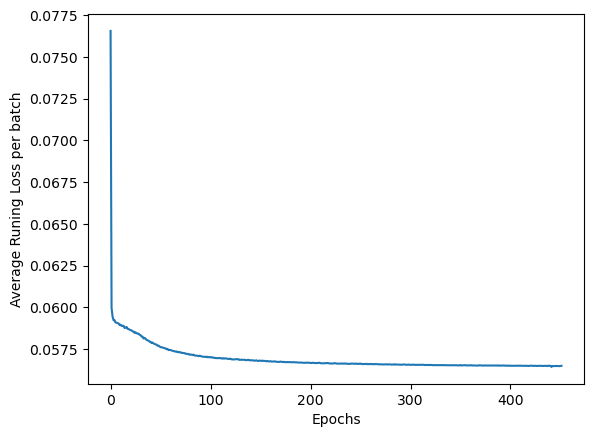

In [29]:
epoch_arr = np.arange(0, len(avg_loss_list))
loss_arr = np.array(avg_loss_list)
plt.plot(avg_loss_list)
plt.xlabel("Epochs")
plt.ylabel("Average Runing Loss per batch")
plt.show()

In [30]:
torch.save(final_model, 'model_100206_7g_03.pt')